In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Variables:

**Logfiles 1 and 2:** 

have the following measurements: thrust,est_x,est_y,est_z,zrange 

During the first experience, I held a paperblock below the drone, which made it think it was lower than it actually was... 

Logfile 2 does a square

**Logfile: straight_over_obatacle.csv** 

data: acc.z, x,y,z,zrange

## Remarks:
- there is an offset in the x,y, coordinates at the beginning --> i don't know where it comes from, but it makes position commands a bit dangerous...
- the position command is "go up(0.5)", but the drone always goes up to ~1m

In [21]:
# import data in pandas dataframe (change the file name to your local file)
data = pd.read_csv('fly_straight1.csv', header = None)

In [22]:
# remove all-zeros rows
data.columns = ['acc','x','y','z','zrange','pressure']
data = data[(data.T != 0).any()]

In [23]:
print(data)

           acc         x         y         z  zrange    pressure
0     0.999048  0.513305  0.495214  0.035673    16.0  969.796021
1     1.000615  0.514103  0.494412  0.036719    16.0  969.796021
2     0.999586  0.513307  0.494671  0.038479    16.0  969.782410
3     0.998972  0.514174  0.494705  0.039638    16.0  969.782410
4     1.002286  0.514343  0.494657  0.040360    16.0  969.782349
...        ...       ...       ...       ...     ...         ...
2015  1.047657  0.832463  0.042334  0.266288   295.0  969.751709
2016  1.032641  0.831795  0.038919  0.258539   295.0  969.751709
2017  1.023440  0.831611  0.029817  0.247564   295.0  969.754517
2018  1.034068  0.831495  0.025826  0.236930   295.0  969.754517
2019  1.043266  0.827186  0.027850  0.221510   295.0  969.755920

[2020 rows x 6 columns]


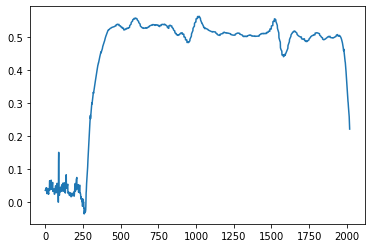

In [64]:
plt.plot(data['z'])
# period is about 175 samples --> 1750 ms

# remove first 400 samples, and last 100 samples for edge detection

In [65]:
z = data[400:-100]['z'].values

Text(0.5, 1.0, 'convolution')

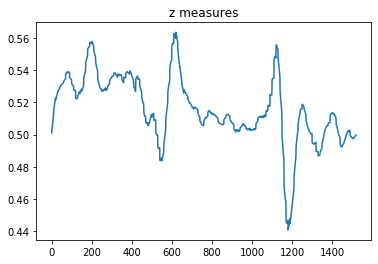

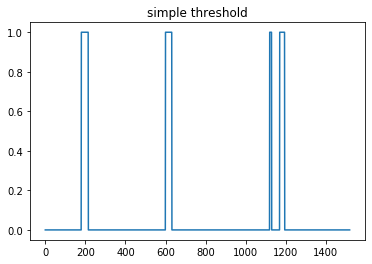

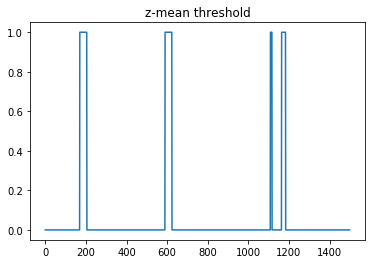

<Figure size 432x288 with 0 Axes>

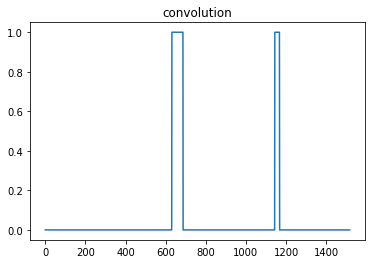

In [66]:
def threshold(zreadings):
    # simple constant threshold on the deviation from height setpoint
    threshold = [abs(x-0.5)>0.05 for x in zreadings]
    return threshold

def moving_mean_threshold(zreadings):
    # thresholding on the mean of the deviation from the height setpoint over some time window
    n_samples = 20
    mean_zreading = [(np.mean(abs(zreadings[i:i+n_samples]-0.5))>0.05) for i in range(zreadings.shape[0]-n_samples)]
    return mean_zreading

# These results are not really robust to oscillation


def convolution(zreadings):
    # idea: 
    # - convolute with a sinusoidal kernel in time-domain to find if oscillation is taking place
    # - set fixed thresholds on the convolution product
    # - select a kernel with corresponding to the apporximate period oscillation of the drone (175*10ms roughly)
    T = 175 # periodicity is 175*Ts
    kernel = np.sin(np.arange(T-1)/T*2*np.pi)
    #plt.figure()
    #plt.plot(kernel)
    #plt.title('kernel')
    conv_prod = [np.sum(abs(zreadings[i:i+T-1]-0.5)*kernel) for i in range(zreadings.shape[0]-T)]
    plt.figure()
    #plt.plot(conv_prod)
    #plt.title('conv_product')
    #raising = np.array(conv_prod)>2
    edges = np.hstack([np.array([(T-2)*[False]]).flatten(),np.array(conv_prod)<-1.5])
    """
    edges = []
    for x,y in zip(raising,falling):
        if (x and not y):
            edges.append(1)
        elif (y and not x):
            edges.append(-1)
        else:
            edges.append(0)
    """
    return edges
    

plt.figure()
plt.plot(z)
plt.title('z measures')

plt.figure()
z_thresh = threshold(z)
plt.plot(z_thresh)
plt.title('simple threshold')

plt.figure()
z_mean_thresh = moving_mean_threshold(z)
plt.plot(z_mean_thresh)
plt.title('z-mean threshold')

plt.figure()
z_conv = convolution(z)

plt.plot(z_conv)
plt.title('convolution')

# possible issue: does this work in real time??
# need to save about 180 past values in a buffer
# convolute with a kernel of size 180

In [67]:
# check for all available data:

data1 = pd.read_csv('fly_straight1.csv', header = None)
# remove all-zeros rows
data1.columns = ['acc','x','y','z','zrange','pressure']
data1 = data1[(data1.T != 0).any()]
z1 = data1[400:-100]['z'].values

data2 = pd.read_csv('fly_straight2.csv', header = None)
# remove all-zeros rows
data2.columns = ['acc','x','y','z','zrange','pressure']
data2 = data2[(data2.T != 0).any()]
z2 = data2[400:-100]['z'].values

data3 = pd.read_csv('fly_straight3.csv', header = None)
# remove all-zeros rows
data3.columns = ['acc','x','y','z','zrange','pressure']
data3= data3[(data3.T != 0).any()]
z3 = data3[400:-100]['z'].values

Text(0.5, 1.0, 'data 3')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

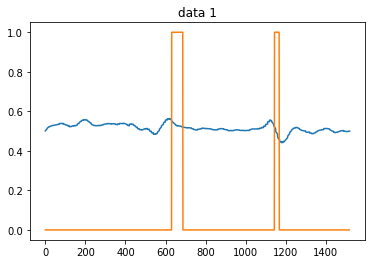

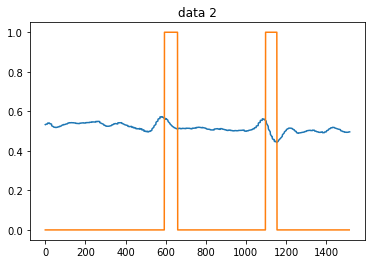

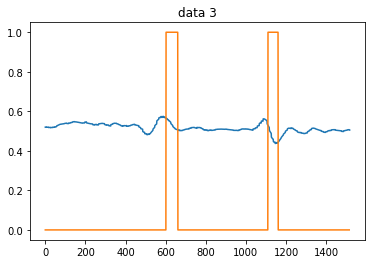

In [68]:
z_conv1 = convolution(z1)
z_conv2 = convolution(z2)
z_conv3 = convolution(z3)

plt.figure()
plt.plot(z1)
plt.plot(z_conv1)
plt.title('data 1')

plt.figure()
plt.plot(z2)
plt.plot(z_conv2)
plt.title('data 2')

plt.figure()
plt.plot(z3)
plt.plot(z_conv3)
plt.title('data 3')